# Modeling Football Player Statistics

For this project, I will be using the data of football players across the top 5 league in Europe during the 2018-19 season.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
bundesliga_df = pd.read_csv("../data/Bundesliga-Summary-2018-2019.csv") 
laLiga_df = pd.read_csv("../data/LaLiga-Summary-2018-2019.csv") 
ligue1_df = pd.read_csv("../data/Ligue1-Summary-2018-2019.csv") 
premierLeague_df = pd.read_csv("../data/PremierLeague-Summary-2018-2019.csv") 
serieA_df = pd.read_csv("../data/SerieA-Summary-2018-2019.csv") 
top5League_df = pd.concat([bundesliga_df, laLiga_df, ligue1_df, premierLeague_df, serieA_df], axis=0)

I have decided to concatenated all the datasets into one single dataframe. This is so that I can save time during the data cleaning and feature engineering process as I only have to operate on one dataframe.

### Data Cleaning and Feature Engineering

In [3]:
top5League_df = top5League_df[(top5League_df["Position"] != "Goalkeeper")]
top5League_df = top5League_df[(top5League_df["Position"] != "GK")]

top5League_df["90-min Games Played"] = top5League_df["Minutes"] / 90

# I wanted to make sure that the included players had at least played half of the games throughout the season.
# A season has 38 games, therefore half of 38 is 19.
top5League_df = top5League_df[(top5League_df["90-min Games Played"] > 19)]

top5League_df["Total Goals"] = top5League_df["Total Goals"].str.replace("-", "0")
top5League_df = top5League_df.astype({"Total Goals": int}) 

top5League_df["Total Assists"] = top5League_df["Total Assists"].str.replace("-", "0")
top5League_df = top5League_df.astype({"Total Assists": int}) 

top5League_df["Goal per Game"] = top5League_df["Total Goals"] / top5League_df["90-min Games Played"]
top5League_df["Assist per Game"] = top5League_df["Total Assists"] / top5League_df["90-min Games Played"]

top5League_df = top5League_df[["Name", "90-min Games Played", "Total Goals", "Total Assists", "Goal per Game", "Assist per Game"]]
top5League_df = top5League_df.reset_index(drop = True)
top5League_df

,Name,90-min Games Played,Total Goals,Total Assists,Goal per Game,Assist per Game
0,Robert Lewandowski,32.877778,22,7,0.669145,0.212910
1,Thiago Alcántara,26.766667,2,6,0.074720,0.224159
2,Kerem Demirbay,22.477778,4,9,0.177954,0.400395
3,Marcel Halstenberg,26.822222,3,6,0.111848,0.223695
4,Sébastien Haller,24.233333,15,9,0.618982,0.371389
...,...,...,...,...,...,...
920,Mirco Antenucci,23.622222,5,0,0.211665,0.000000
921,Mariusz Stepinski,27.511111,6,2,0.218094,0.072698
922,Nicola Rigoni,21.755556,0,1,0.000000,0.045965
923,Frederic Veseli,28.188889,0,0,0.000000,0.000000


### Formulate ideas on how machine learning can be used to model distributions within the dataframe

To accomplish this, I will be using the K-means clustering algorithm to model a dataframe consisting of a players' goal and assist ratio. My goal is to model the dataframe by grouping the players into 4 different clusers. This is beacause, I hypothesize that football players generally have 4 archetypes and that the 4 archetypes are:
1. The Defender (low # of goals, low # assists)
2. The Midfielder (moderate # of goals, high # of assists)
3. The Forward (high # of goals, moderate # of assists)
4. The Anomaly Superstar (high # of goals, high # of assists)


The reason why I chose the K-means clustering algorithm is because it is easy to implement and extremely fast. 

#### Visualization of initial scatter 
Something to note here is that the clusers are not well separated.

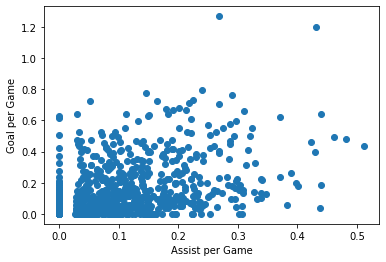

In [4]:
plt.scatter(top5League_df["Assist per Game"], top5League_df["Goal per Game"])
plt.xlabel("Assist per Game")
plt.ylabel("Goal per Game");

### Building the algorithm to model the dataframe

#### K-means Algorithm Implementation
As I previously mentioned, since I have decided to have 4 different clusters, K will be set to 4. Also, as the K-means algorithm is an iterative algorithm, I have decided to have it go through 10 iterations as I feel like it is enough to reach our ideal cluster positions and because I do not want to overwhelm the reader with too many visualization. 

#### Visualization
On each of the 10 scatter plots, the black dots represents a single cluster. We should be able to see the cluster shifting towards the maxima after each iteration.

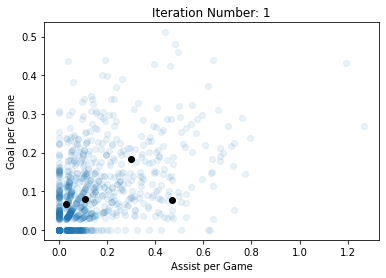

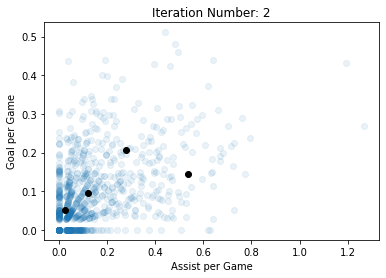

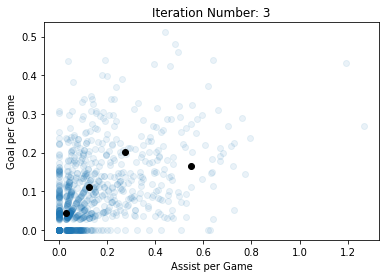

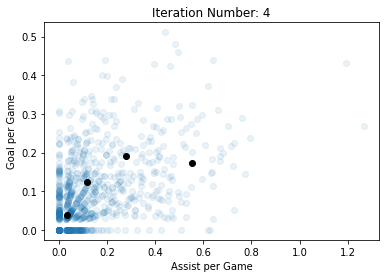

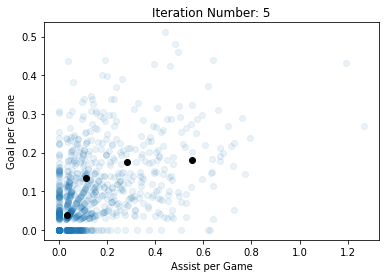

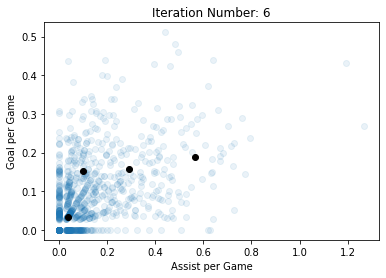

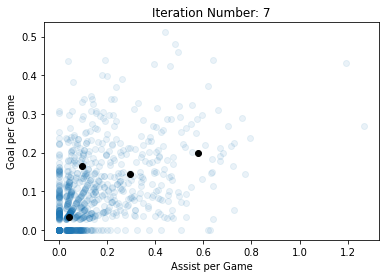

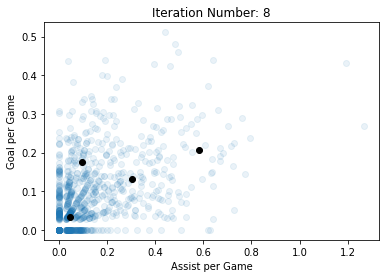

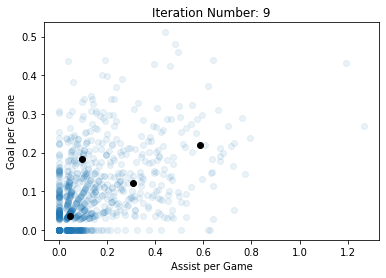

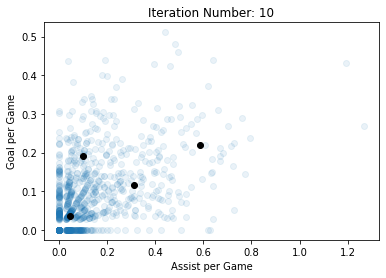

In [5]:
goal_and_assist_array = np.array(top5League_df[["Goal per Game", "Assist per Game"]])
init_centroids = random.sample(range(0, len(goal_and_assist_array)), 4)

cluster_centroids = []
for c in init_centroids:
    cluster_centroids.append(goal_and_assist_array[c])
    
for i in range(10):
    clusters = []
    for x in goal_and_assist_array:
        distances = []
        for c in cluster_centroids:
            distance = sum(((x - c)**2))**0.5
            distances.append(distance)
        clusters.append(np.argmin(distances))
        
    new_centroids = []
    new_df = pd.concat([pd.DataFrame(goal_and_assist_array), pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    for c in set(new_df['cluster']):
        current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    
    cluster_centroids = new_centroids
    
    plt.scatter(goal_and_assist_array[:, 0], goal_and_assist_array[:, 1], alpha=0.09)
    plt.scatter(np.array(cluster_centroids)[:, 0], np.array(cluster_centroids)[:, 1], color='black')
    plt.title("Iteration Number: " + str(i+1))
    plt.xlabel("Assist per Game")
    plt.ylabel("Goal per Game");
    plt.show()

### Conclusion

As we can identify from the final iteration of the scatter plot, the position of clusters has matched our hypothesis which states that football players generally have 4 archetypes. 
1. The Defender (low # of goals, low # assists) - Positioned around the bottom left of the scatter plot
2. The Midfielder (moderate # of goals, high # of assists) - On the position (x,y) s.t 0.2 < x < 0.4 and y = ~0.1
3. The Forward (high # of goals, moderate # of assists) - On the position (x,y) s.t 0.0 < x < 0.2 and y = ~0.2
4. The Anomaly Superstar (high # of goals, high # of assists) - Positioned around the middle of the scatter plot

That being said, one thing that suprised me is that the Anomaly Superstar cluster has a much higher assist ratio then the Midfielder cluster. However, overall, I am very satisfied with the K-means clustered model of the dataframe consisting of a players' assist and goal ratio in the 2018-19 season across the top 5 European league.